<a href="https://colab.research.google.com/github/AkerkeKesha/stacked-unets/blob/main/gcolab_etci_flood_semantic_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Set up plotting options
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [ ]:
gdrive_root = '/content/drive/MyDrive/stacked-unet/dataset/etci-flood-dataset'
gdrive_root

'/content/drive/MyDrive/stacked-unet/dataset/etci-flood-dataset'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!git clone https://github.com/AkerkeKesha/stacked-unets.git

Cloning into 'stacked-unets'...
remote: Enumerating objects: 1041, done.
remote: Counting objects: 100% (161/161), done.
remote: Compressing objects: 100% (95/95), done.
remote: Total 1041 (delta 105), reused 116 (delta 66), pack-reused 880
Receiving objects: 100% (1041/1041), 2.24 MiB | 33.72 MiB/s, done.
Resolving deltas: 100% (709/709), done.


In [ ]:
%cd stacked-unets

/content/stacked-unets


In [ ]:
%pip install -r requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 56.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.9/121.9 kB 16.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 8.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 90.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.8/294.8 kB 35.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 31.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.4/93.4 kB 13.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 87.3 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16428 sha256=c16f0c70fd6a1b594a5672e65d5d9360acbf01de162488246b4c1d8bcde04158
  Stored in direct

In [ ]:
!mkdir -p /content/stacked-unets/dataset/data-etci-flood

In [ ]:
!unzip -q $gdrive_root/train.zip -d /content/stacked-unets/dataset/data-etci-flood

# Couple check ups

In [ ]:
%pwd

'/content/stacked-unets'

In [ ]:
!git stash

Saved working directory and index state WIP on main: b992f1f chores: improved output path name


In [ ]:
!git fetch

remote: Enumerating objects: 7, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (1/1), done.
remote: Total 4 (delta 3), reused 4 (delta 3), pack-reused 0
Unpacking objects: 100% (4/4), 419 bytes | 419.00 KiB/s, done.
From https://github.com/AkerkeKesha/stacked-unets
   1417cc3..451f1ae  main       -> origin/main


In [ ]:
!git pull

Updating 1417cc3..451f1ae
Fast-forward
 src/main.py | 1 +
 1 file changed, 1 insertion(+)


In [ ]:
import torch

gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU is not available, using CPU instead")

Fri Sep 15 10:02:33 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P0    43W / 400W |      0MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from psutil import virtual_memory

ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 89.6 gigabytes of available RAM

You are using a high-RAM runtime!


In [ ]:
import sys

sys.path.append('/content/stacked-unets/src')

In [ ]:
import os

os.environ['ENVIRONMENT'] = 'colab'
os.environ['DATASET'] = 'etci'

In [ ]:
import os
from glob import glob
import config


train_dir = config.train_dir

print(f"Is colab: {config.dataset}")
print(f"Is colab: {config.environment}")

print(f"Number of training temporal-regions: {len(glob(train_dir+'/*/'))}")

Is colab: etci
Is colab: colab
Number of training temporal-regions: 31


Split into train:(20019, 6), validation:(2502, 6), and test:(2503, 6)
Level: [1 / 5]


  0%|          | 0/418 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/418 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/418 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/418 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/418 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

Generating semantic maps for train dataset...


  0%|          | 0/418 [00:00<?, ?it/s]

Generating semantic maps for val dataset...


  0%|          | 0/53 [00:00<?, ?it/s]

Done saving evaluation metrics/losses on train/val


100%|██████████| 53/53 [00:32<00:00,  1.64it/s]


Mean IoU for the test dataset: 0.7487402594026059
Level: [2 / 5]


  0%|          | 0/418 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/418 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/418 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/418 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/418 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/418 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/418 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/418 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/418 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/418 [00:00<?, ?it/s]

Epoch: [10 / 20]
Train mean IoU = 0.7853
Train mean loss = 0.0365


  0%|          | 0/53 [00:00<?, ?it/s]

Val mean IoU = 0.7809
Val mean loss = 0.0324


  0%|          | 0/418 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/418 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/418 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/418 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/418 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/418 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/418 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/418 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/418 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/418 [00:00<?, ?it/s]

Epoch: [20 / 20]
Train mean IoU = 0.8097
Train mean loss = 0.0322


  0%|          | 0/53 [00:00<?, ?it/s]

Val mean IoU = 0.7474
Val mean loss = 0.0472
Generating semantic maps for train dataset...


  0%|          | 0/418 [00:00<?, ?it/s]

Generating semantic maps for val dataset...


  0%|          | 0/53 [00:00<?, ?it/s]

Done saving evaluation metrics/losses on train/val


100%|██████████| 53/53 [00:35<00:00,  1.50it/s]


Mean IoU for the test dataset: 0.7198259304531572
Level: [3 / 5]


  0%|          | 0/418 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/418 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/418 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/418 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/418 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/418 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/418 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/418 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/418 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/418 [00:00<?, ?it/s]

Epoch: [10 / 20]
Train mean IoU = 0.7856
Train mean loss = 0.0364


  0%|          | 0/53 [00:00<?, ?it/s]

Val mean IoU = 0.7925
Val mean loss = 0.0324


  0%|          | 0/418 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/418 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/418 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/418 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/418 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/418 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/418 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/418 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/418 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/418 [00:00<?, ?it/s]

Epoch: [20 / 20]
Train mean IoU = 0.8123
Train mean loss = 0.0314


  0%|          | 0/53 [00:00<?, ?it/s]

Val mean IoU = 0.8039
Val mean loss = 0.0288
Generating semantic maps for train dataset...


  0%|          | 0/418 [00:00<?, ?it/s]

Generating semantic maps for val dataset...


  0%|          | 0/53 [00:00<?, ?it/s]

Done saving evaluation metrics/losses on train/val


100%|██████████| 53/53 [00:32<00:00,  1.62it/s]


Mean IoU for the test dataset: 0.7938219332930361
Level: [4 / 5]


  0%|          | 0/418 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/418 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/418 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/418 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/418 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/418 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/418 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/418 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/418 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/418 [00:00<?, ?it/s]

Epoch: [10 / 20]
Train mean IoU = 0.7874
Train mean loss = 0.0368


  0%|          | 0/53 [00:00<?, ?it/s]

Val mean IoU = 0.7246
Val mean loss = 0.0367


  0%|          | 0/418 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/418 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/418 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/418 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/418 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/418 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/418 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/418 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/418 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/418 [00:00<?, ?it/s]

Epoch: [20 / 20]
Train mean IoU = 0.8165
Train mean loss = 0.0313


  0%|          | 0/53 [00:00<?, ?it/s]

Val mean IoU = 0.8024
Val mean loss = 0.0291
Generating semantic maps for train dataset...


  0%|          | 0/418 [00:00<?, ?it/s]

Generating semantic maps for val dataset...


  0%|          | 0/53 [00:00<?, ?it/s]

Done saving evaluation metrics/losses on train/val


100%|██████████| 53/53 [00:33<00:00,  1.60it/s]


Mean IoU for the test dataset: 0.7864867155908561
Level: [5 / 5]


  0%|          | 0/418 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/418 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/418 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/418 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/418 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/418 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/418 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/418 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/418 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/418 [00:00<?, ?it/s]

Epoch: [10 / 20]
Train mean IoU = 0.7846
Train mean loss = 0.0354


  0%|          | 0/53 [00:00<?, ?it/s]

Val mean IoU = 0.7084
Val mean loss = 0.0360


  0%|          | 0/418 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/418 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/418 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/418 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/418 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/418 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/418 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/418 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/418 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/418 [00:00<?, ?it/s]

Epoch: [20 / 20]
Train mean IoU = 0.8167
Train mean loss = 0.0304


  0%|          | 0/53 [00:00<?, ?it/s]

Val mean IoU = 0.8118
Val mean loss = 0.0265
Generating semantic maps for train dataset...


  0%|          | 0/418 [00:00<?, ?it/s]

Generating semantic maps for val dataset...


  0%|          | 0/53 [00:00<?, ?it/s]

Done saving evaluation metrics/losses on train/val


100%|██████████| 53/53 [00:33<00:00,  1.60it/s]


Mean IoU for the test dataset: 0.7920238880717813


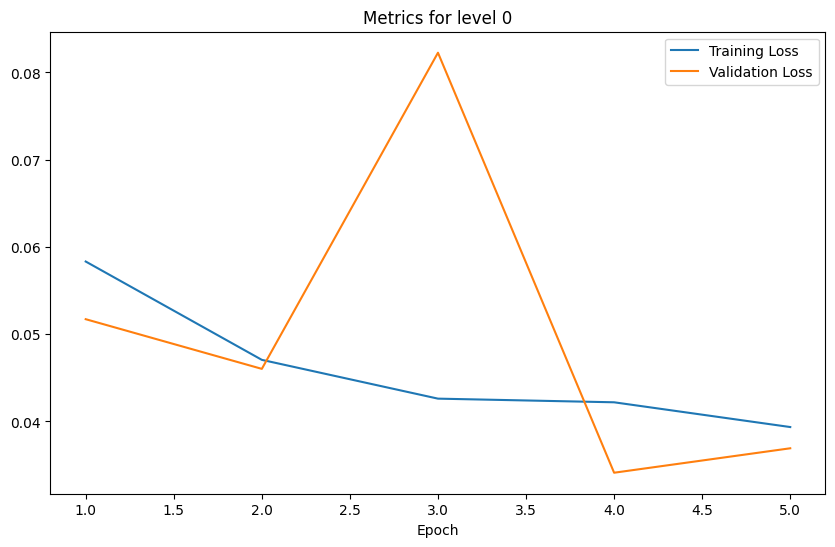

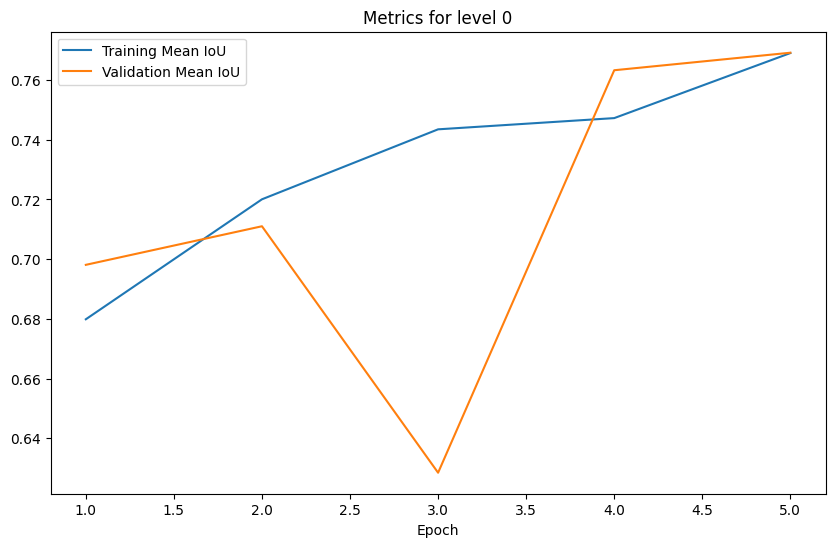

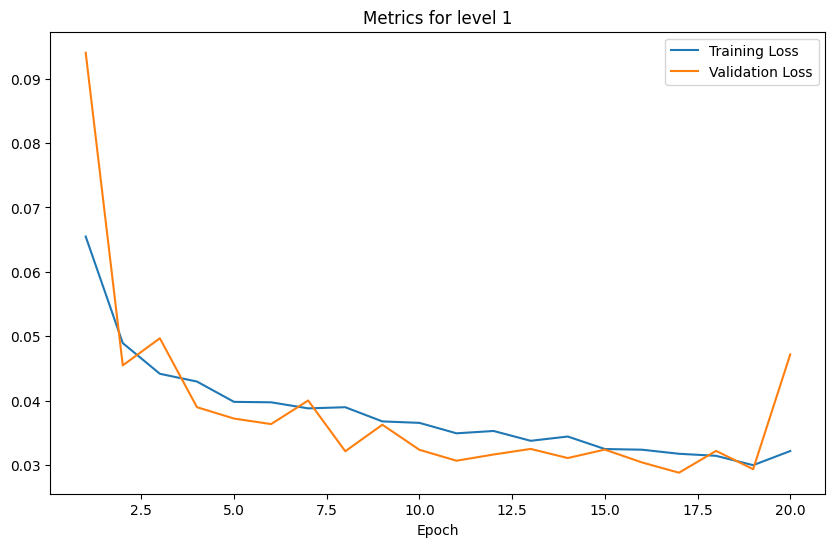

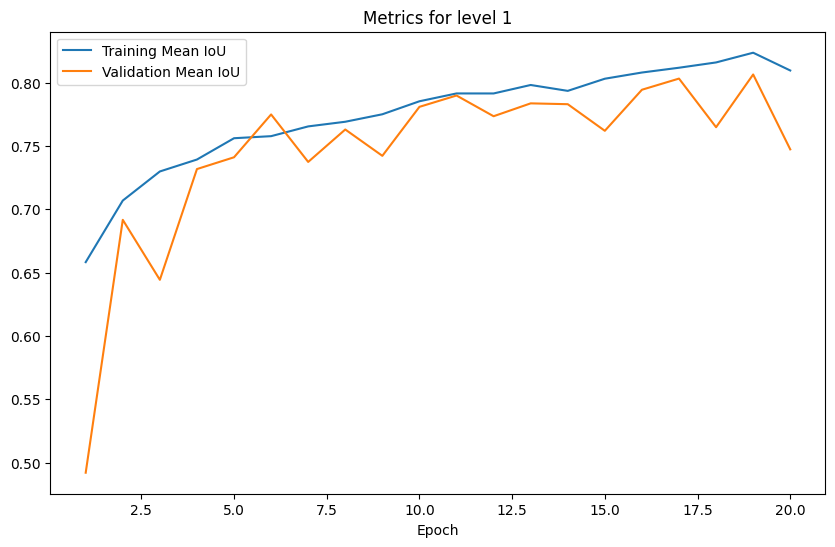

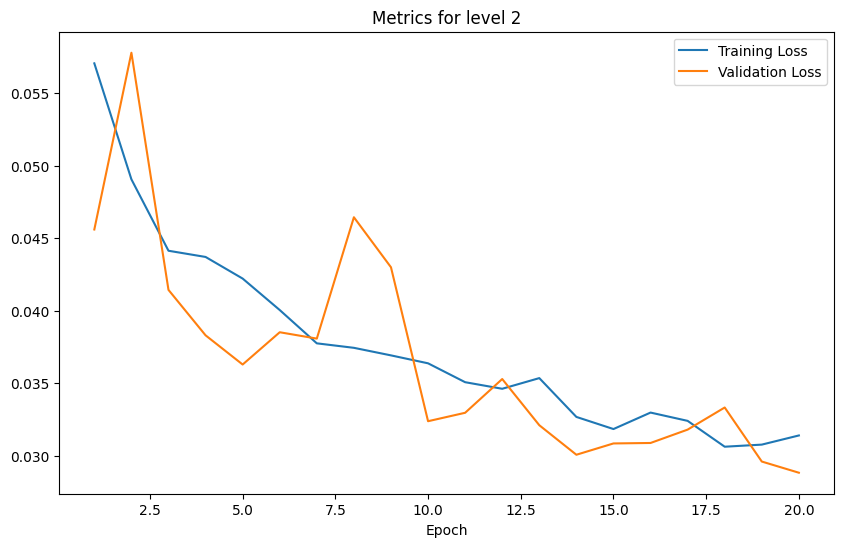

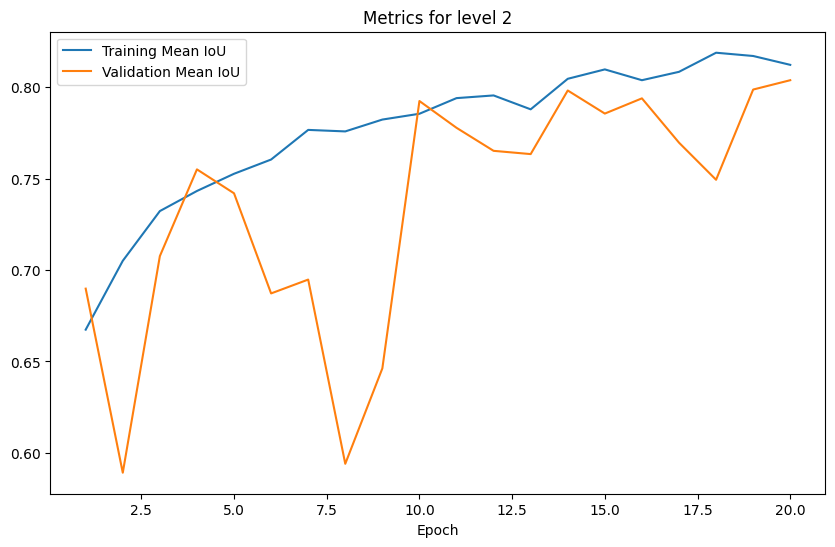

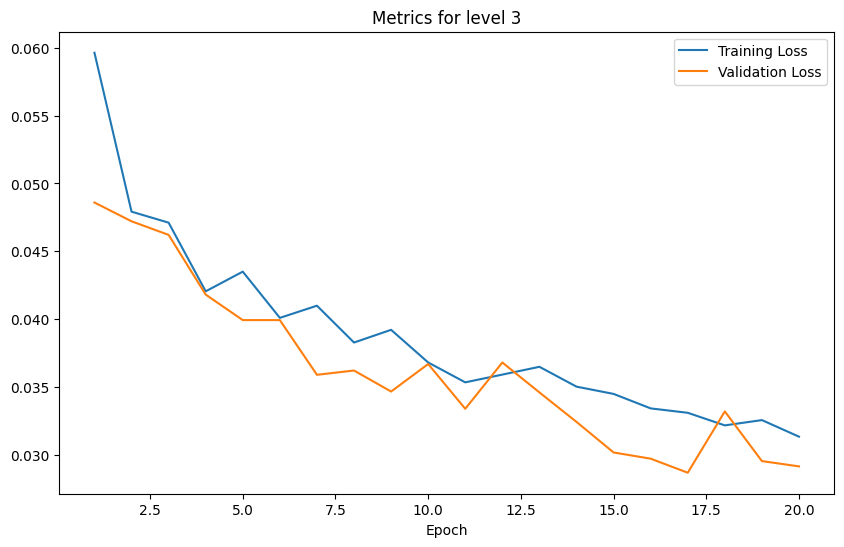

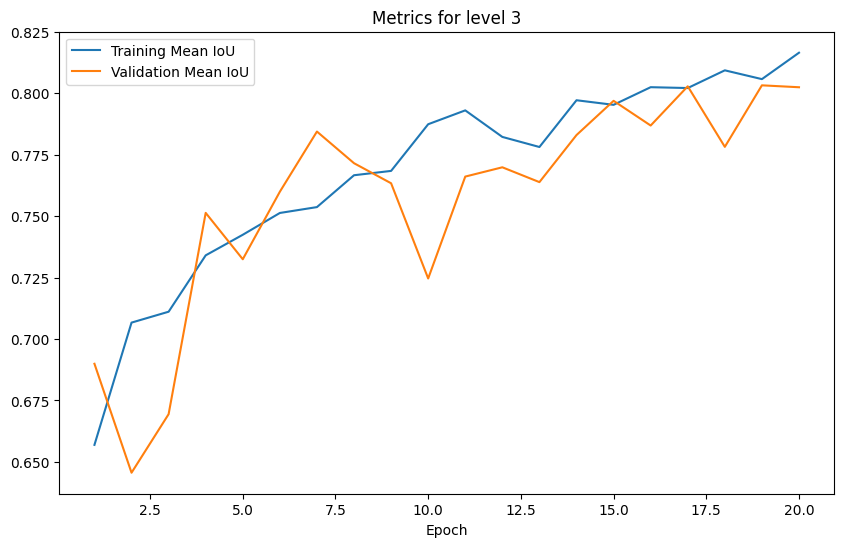

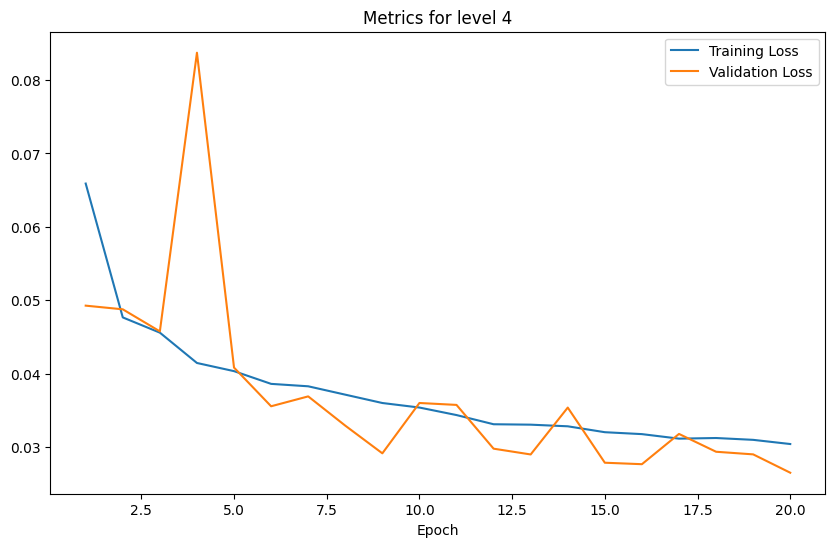

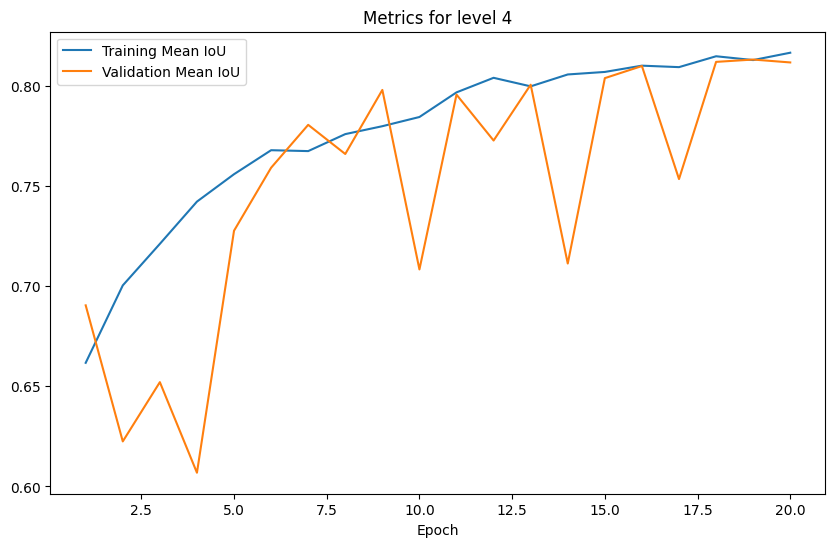

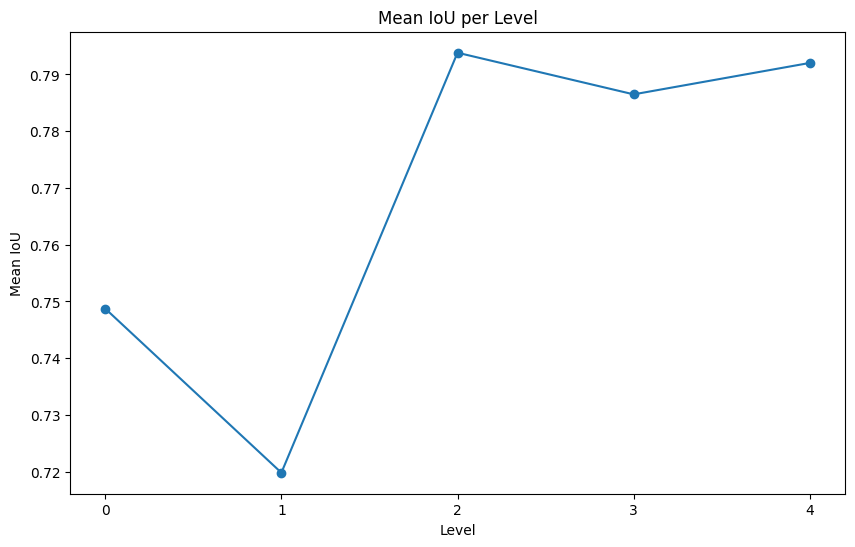

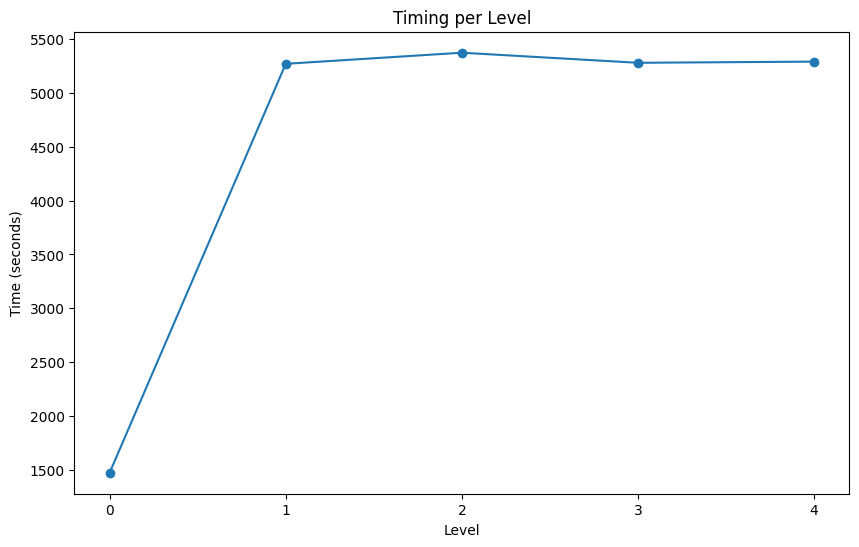

Done plotting results


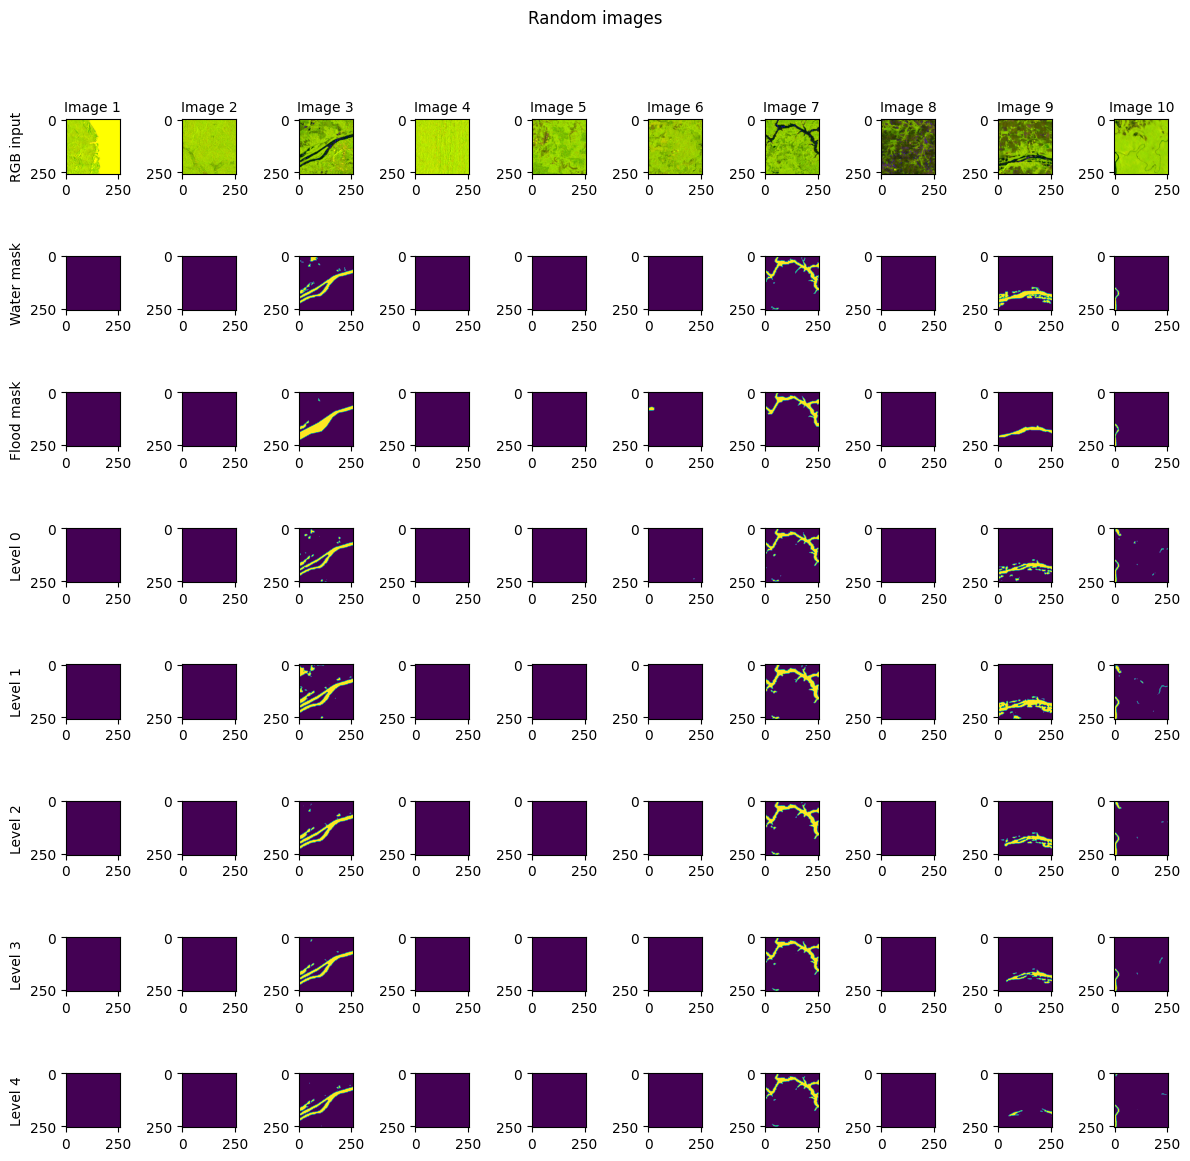

In [ ]:
from src.main import start_stacked_unet

start_stacked_unet(n_levels=5)

In [ ]:
!zip -r output_5level.zip output > /dev/null 2>&1

In [ ]:
!cp output_5level.zip "/content/drive/MyDrive/stacked-unet/output_5level.zip"

In [ ]:
!ls output/etci_labels | wc -l

125120
